# Load Data

In [1]:
from pathlib import Path
import sys

# More reliable: get the project root from the notebook's location
ROOT_PATH = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
# Or even better for notebooks:
ROOT_PATH = Path().resolve().parent  # Goes up from notebooks/ folder

sys.path.append(str(ROOT_PATH))

from src.data.dataset import OrionAEFrameDataset

train_set = OrionAEFrameDataset(
    data_path=r"C:\Users\nguye\Documents\GitHub\orion-ae-study\data\raw\segmented_ms_30_0_o_0_00_c_A_B_C_D_20251213_092549",
    config_path=r"C:\Users\nguye\Documents\GitHub\orion-ae-study\configs\dataset\example_1.yaml",
    type="train"
)

In [2]:
exp_sample = train_set[0]['raw'][:, :-1]

In [3]:
from matplotlib import pyplot as plt

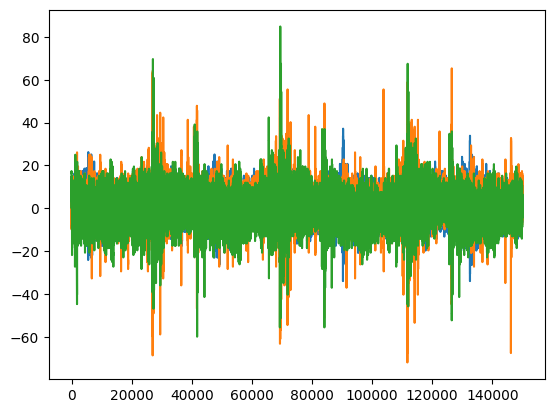

In [4]:
plt.plot(exp_sample)

# II. Preprocessing

## 2.1. Filters

### High-pass Filter

A high-pass filter isolates the true acoustic emission band (100–500 kHz) from low-frequency mechanical noise (shaker vibrations, structural vibrations, power-line interference). 

**Configuration:** Butterworth IIR, cutoff = 100 kHz, order = 5

This choice is standard in bolt-tightening AE literature and removes noise that would otherwise distort normalization statistics and mask weak AE bursts, while matching the natural high-pass characteristics of AE sensors.


In [5]:
exp_sample

array([[ 6.530961 , -3.295999 , 16.296885 ],
       [ 6.530961 , -3.295999 , 16.296885 ],
       [ 5.432295 , -2.1973326, 17.39555  ],
       ...,
       [12.024293 , -1.0986663, -3.295999 ],
       [ 8.728293 , -5.493332 , -4.3946652],
       [ 6.530961 , -4.3946652,  1.0376294]],
      shape=(150000, 3), dtype=float32)

In [6]:
from scipy.signal import butter, sosfilt
import numpy as np

sos = butter(5, 100000, btype='high', fs=5000000, output='sos')
# Apply to multi-channel frame (shape: samples, channels)
# sosfilt expects shape (..., n_samples) so we need to transpose
filtered_sample = sosfilt(sos, exp_sample.T).T  # (3, 150000) → filter → (3, 150000) → transpose back

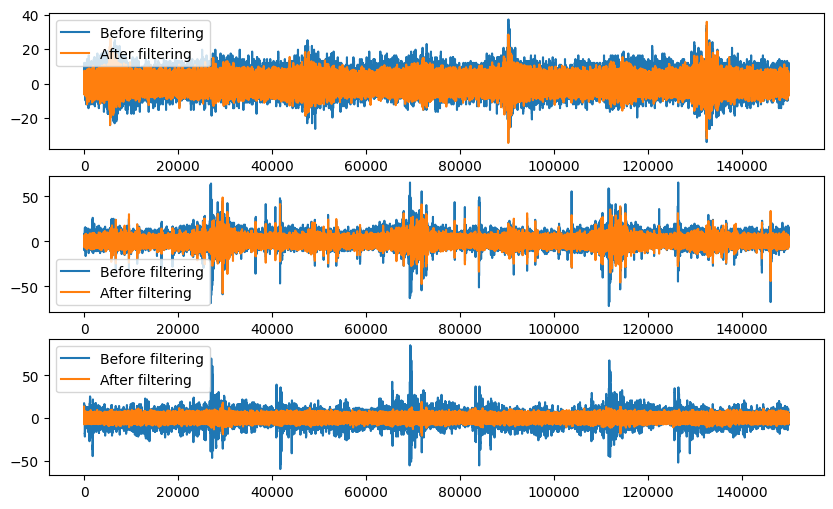

In [7]:
# visualize signal before and after filtering at each channel
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
for i in range(3):
    axs[i].plot(exp_sample[:, i], label='Before filtering')
    axs[i].plot(filtered_sample[:, i], label='After filtering')
    axs[i].legend()
plt.show()


### Wavelet Denoising

After high-pass filtering removes low-frequency mechanical noise, wavelet denoising removes remaining high-frequency noise (electronic, thermal, sensor self-noise) while preserving transient AE bursts.

**Configuration:** Symlet-5 (sym5), decomposition level 6, soft thresholding

Wavelet denoising exploits the fact that AE bursts appear as large wavelet coefficients at specific time-frequency locations, while noise is scattered across many small coefficients. Thresholding isolates true AE events and improves signal-to-noise ratio before feature extraction or model input.


In [8]:
from scipy.stats import median_abs_deviation
import pywt

#### Step 1: Decompose (break signal into layers)
- Splits the signal into 7 parts: 1 approximation + 6 detail levels
- Each level captures different frequency bands
- High frequencies (noise) → detail coefficients at higher levels
- Low frequencies (signal) → approximation coefficient

In [9]:
import pywt
import numpy as np

# Your signal after high-pass
signal_hp = np.random.randn(150000, 3)  # shape: (samples, channels)

# Decompose each channel separately
wavelet = "sym5"
level = 6

denoised_channels = []
chn_coeffs = []

for ch_idx in range(signal_hp.shape[1]):
    # Extract one channel: (150000,)
    ch = signal_hp[:, ch_idx]
    
    # Decompose into 7 parts: [approx, det1, det2, det3, det4, det5, det6]
    coeffs = pywt.wavedec(ch, wavelet, level=level)
    # coeffs[0] shape: ~2344 (approximation)
    # coeffs[1] shape: ~4687 (detail level 1, highest freq)
    # coeffs[2] shape: ~9375
    # coeffs[3] shape: ~18750
    # coeffs[4] shape: ~37500
    # coeffs[5] shape: ~75000
    # coeffs[6] shape: ~150000 (detail level 6, lowest freq in details)

    chn_coeffs.append(coeffs)

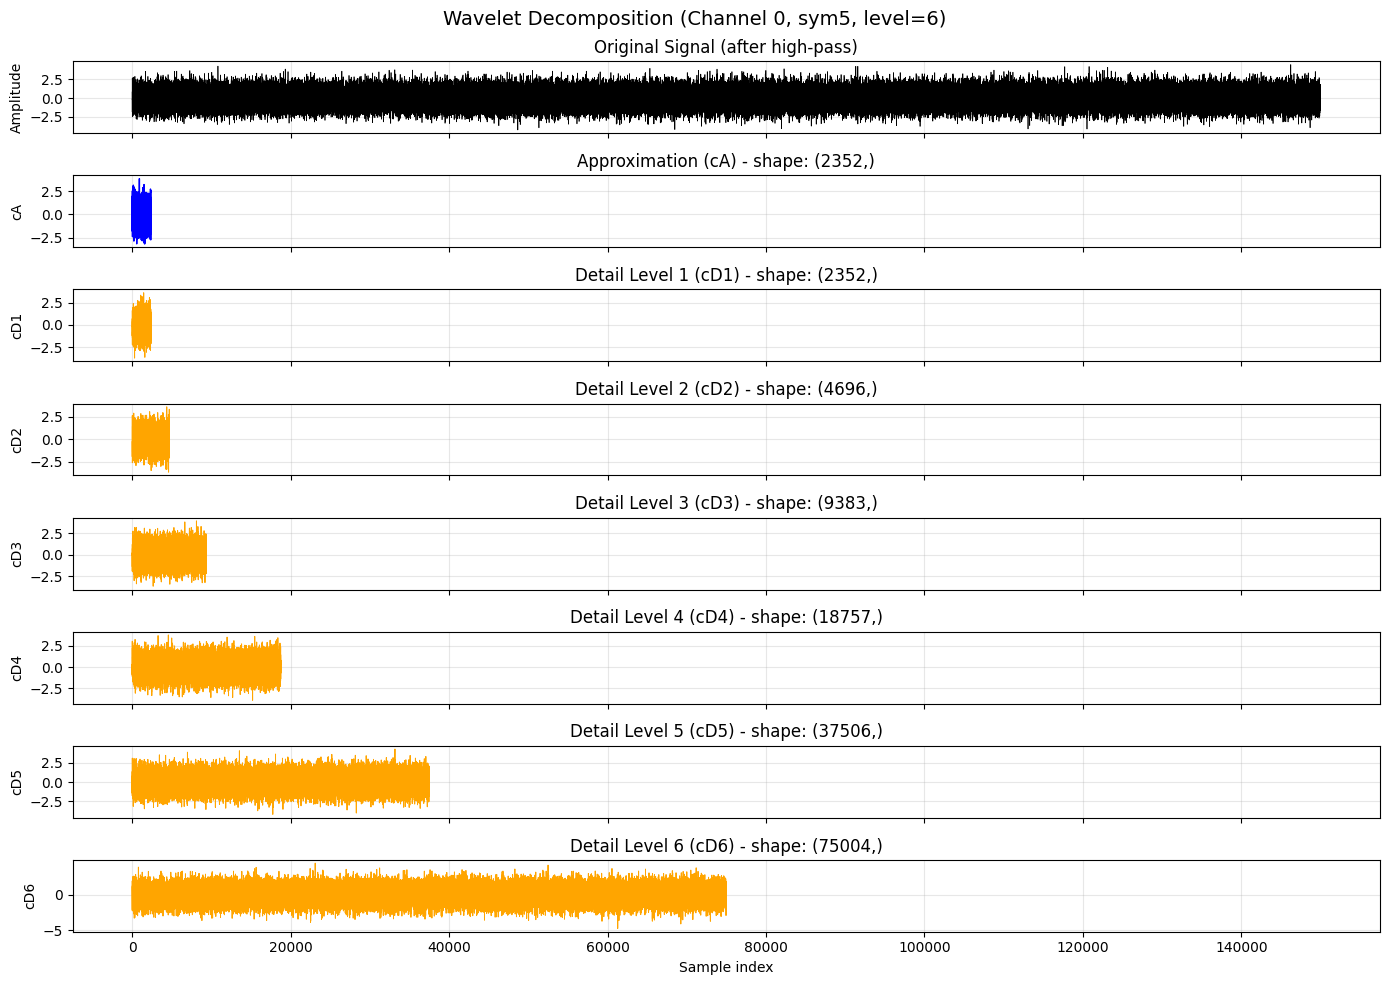

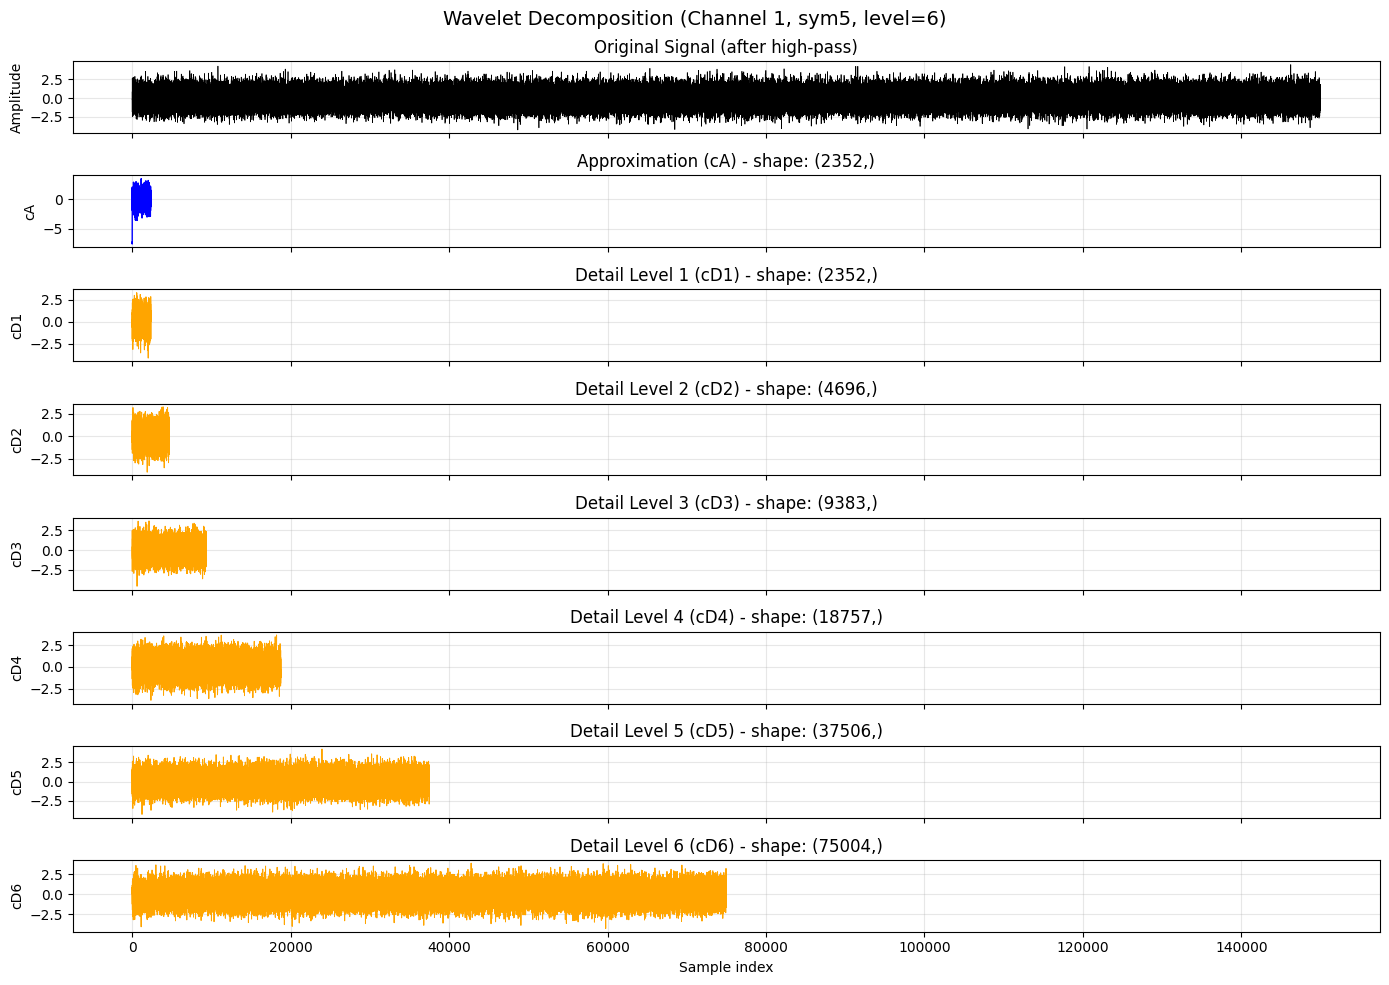

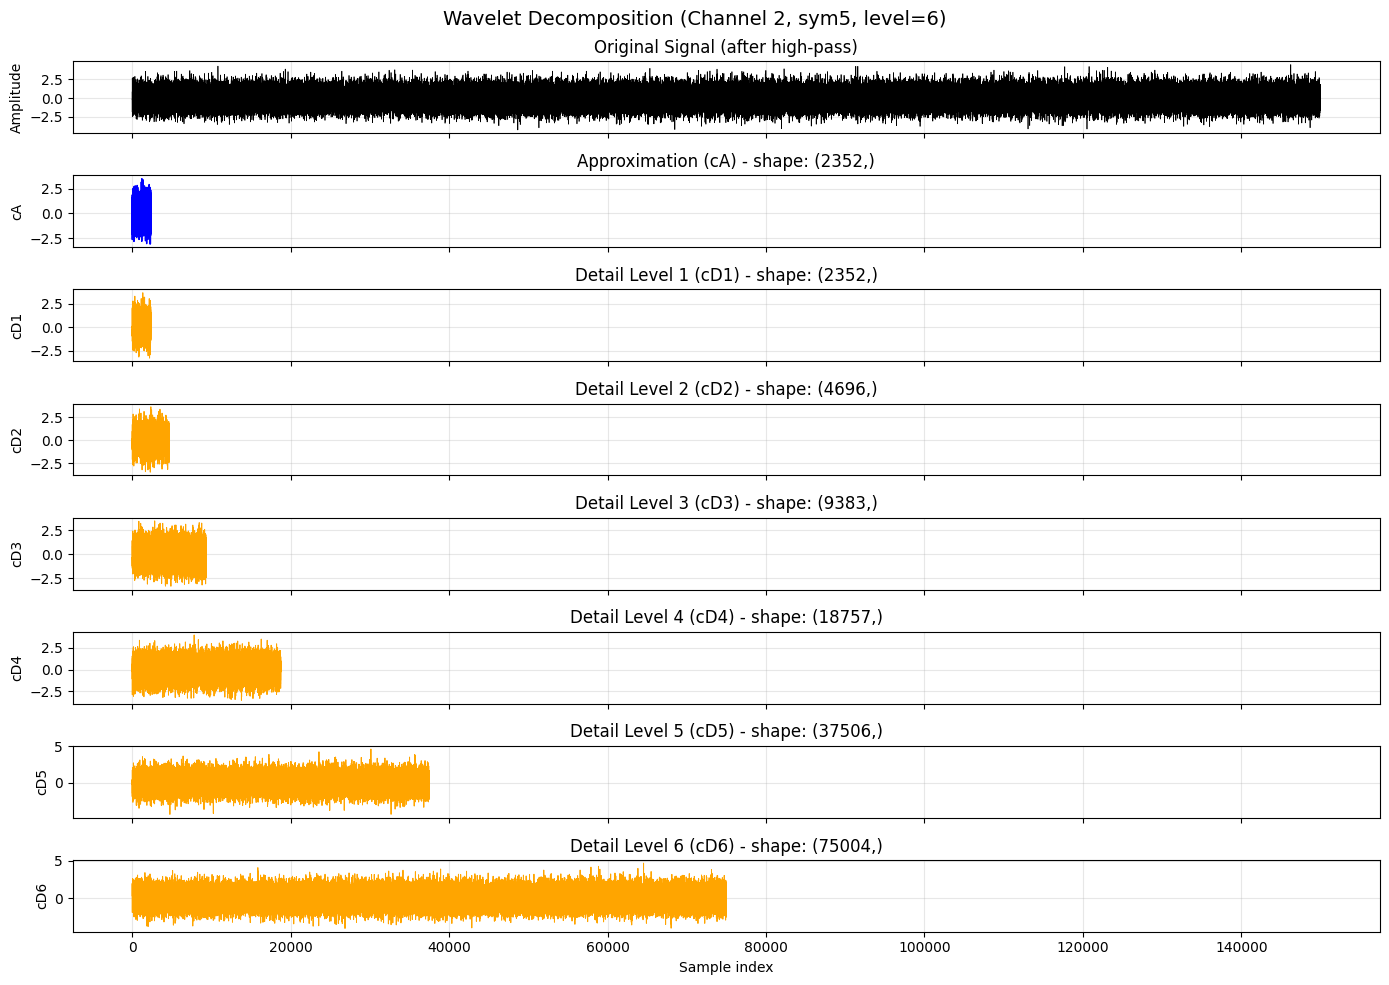

In [10]:
import matplotlib.pyplot as plt

# For each channel, visualize wavelet decomposition
for ch_idx in range(signal_hp.shape[1]):
    
    # Create figure for this channel
    fig, axes = plt.subplots(level + 2, 1, figsize=(14, 10), sharex=True)
    fig.suptitle(f"Wavelet Decomposition (Channel {ch_idx}, {wavelet}, level={level})", fontsize=14)

    # Plot original signal
    axes[0].plot(ch, color='black', linewidth=0.5)
    axes[0].set_title("Original Signal (after high-pass)")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True, alpha=0.3)

    # Plot approximation
    axes[1].plot(chn_coeffs[ch_idx][0], color='blue', linewidth=1)
    axes[1].set_title(f"Approximation (cA) - shape: {coeffs[0].shape}")
    axes[1].set_ylabel("cA")
    axes[1].grid(True, alpha=0.3)

    # Plot detail coefficients
    for i in range(1, len(chn_coeffs[ch_idx])):
        axes[i + 1].plot(chn_coeffs[ch_idx][i], color='orange', linewidth=0.7)
        axes[i + 1].set_title(f"Detail Level {i} (cD{i}) - shape: {chn_coeffs[ch_idx][i].shape}")
        axes[i + 1].set_ylabel(f"cD{i}")
        axes[i + 1].grid(True, alpha=0.3)

    axes[-1].set_xlabel("Sample index")
    plt.tight_layout()
    plt.show()


#### Step 2: Estimate noise (σ) per detail level of channel

- Measures how much noise is in each detail coefficient
- Uses MAD (Median Absolute Deviation) because it's robust (not fooled by outliers like AE bursts)

1. Why use Median Absolute Deviation (MAD)?
MAD is robust to outliers:
Most detail coefficients (cD) are noise (small values)
A few coefficients are AE bursts (large outliers)
Standard deviation is sensitive to outliers
MAD uses the median, so outliers don't skew the estimate

2. Why divide by 0.6745?
- MAD to standard deviation conversion:
- MAD measures spread, but it's not directly comparable to standard deviation
- For a normal distribution: MAD ≈ 0.6745 × σ
- Therefore: σ ≈ MAD / 0.6745

The 0.6745 constant:
- Comes from the inverse of the 75th percentile of the standard normal distribution
- For normal noise: P(|X| ≤ 0.6745σ) = 0.5 (50% of values within ±0.6745σ)
- This scaling converts MAD to an equivalent standard deviation estimate

3. Why this works for noise estimation?
Statistical assumption:
- Most wavelet detail coefficients represent noise
- Noise is approximately normally distributed
- AE bursts are sparse outliers (few large coefficients)

The process:
- Compute MAD of all coefficients → captures the spread of the majority (noise)
- Divide by 0.6745 → converts to standard deviation units
- Result: σ estimates the noise level, ignoring AE burst outliers

In [12]:
from scipy.stats import median_abs_deviation

chn_coeff_sigmas = []

for ch_idx in range(signal_hp.shape[1]):
    
    # For this channel's detail coefficients
    denoised_coeffs = [chn_coeffs[ch_idx][0]]  # Keep approximation as-is

    coeff_sigmas = []
    
    for cD in chn_coeffs[ch_idx][1:]:  # Loop through detail levels 1-6
        # Estimate sigma per detail level
        sigma = median_abs_deviation(cD) / 0.6745

        coeff_sigmas.append(sigma)
        
        # # Use len(cD) for threshold calculation
        # thr = sigma * np.sqrt(2 * np.log(len(cD)))
        
        # print(f"Channel {ch_idx}, detail level {i}, sigma={sigma:.4f}, thr={thr:.4f}")

    chn_coeff_sigmas.append(coeff_sigmas)        


In [13]:
chn_coeff_sigmas

[[np.float64(1.023152716952454),
  np.float64(1.0030558788587398),
  np.float64(1.0119587273557358),
  np.float64(0.9932269521628074),
  np.float64(0.9991369515759237),
  np.float64(0.990019845502744)],
 [np.float64(1.0199698427695498),
  np.float64(0.981828482167128),
  np.float64(0.9716714865615825),
  np.float64(0.9883300952812055),
  np.float64(0.9909386608448978),
  np.float64(1.0035842492050835)],
 [np.float64(1.018063251617059),
  np.float64(0.9840292389528589),
  np.float64(0.9881094524394789),
  np.float64(0.9927491857336791),
  np.float64(0.9967435298219709),
  np.float64(1.0080278738507555)]]

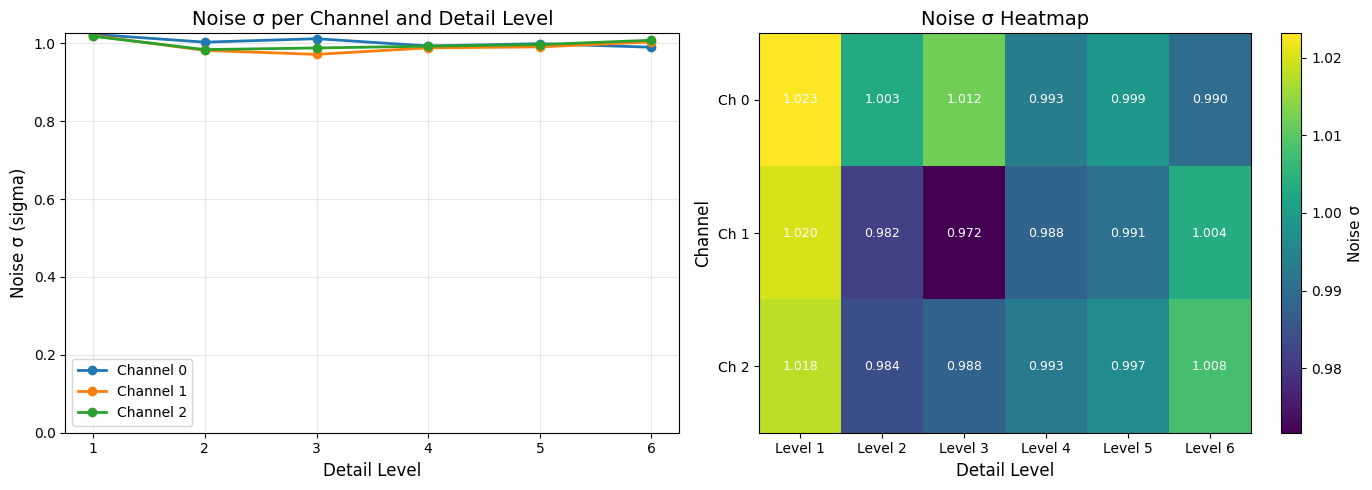


Summary Statistics:
Shape: (3, 6) (channels × detail levels)

Per Channel (mean σ across all detail levels):
  Channel 0: mean=1.0034, std=0.0113
  Channel 1: mean=0.9927, std=0.0155
  Channel 2: mean=0.9980, std=0.0117

Per Detail Level (mean σ across all channels):
  Level 1: mean=1.0204, std=0.0021
  Level 2: mean=0.9896, std=0.0095
  Level 3: mean=0.9906, std=0.0165
  Level 4: mean=0.9914, std=0.0022
  Level 5: mean=0.9956, std=0.0034
  Level 6: mean=1.0005, std=0.0077


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array for easier manipulation
sigmas_array = np.array(chn_coeff_sigmas)  # Shape: (num_channels, num_detail_levels)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Line plot - sigma vs detail level for each channel
ax1 = axes[0]
detail_levels = range(1, sigmas_array.shape[1] + 1)

for ch_idx in range(sigmas_array.shape[0]):
    ax1.plot(detail_levels, sigmas_array[ch_idx], marker='o', label=f'Channel {ch_idx}', linewidth=2)

ax1.set_xlabel('Detail Level', fontsize=12)
ax1.set_ylabel('Noise σ (sigma)', fontsize=12)
ax1.set_title('Noise σ per Channel and Detail Level', fontsize=14)
ax1.set_xticks(detail_levels)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(bottom=0)

# Plot 2: Heatmap - channels vs detail levels
ax2 = axes[1]
im = ax2.imshow(sigmas_array, aspect='auto', cmap='viridis', interpolation='nearest')
ax2.set_xlabel('Detail Level', fontsize=12)
ax2.set_ylabel('Channel', fontsize=12)
ax2.set_title('Noise σ Heatmap', fontsize=14)
ax2.set_xticks(range(sigmas_array.shape[1]))
ax2.set_xticklabels([f'Level {i+1}' for i in range(sigmas_array.shape[1])])
ax2.set_yticks(range(sigmas_array.shape[0]))
ax2.set_yticklabels([f'Ch {i}' for i in range(sigmas_array.shape[0])])

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Noise σ', fontsize=11)

# Add text annotations on heatmap
for i in range(sigmas_array.shape[0]):
    for j in range(sigmas_array.shape[1]):
        text = ax2.text(j, i, f'{sigmas_array[i, j]:.3f}',
                       ha="center", va="center", color="white", fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Shape: {sigmas_array.shape} (channels × detail levels)")
print(f"\nPer Channel (mean σ across all detail levels):")
for ch_idx in range(sigmas_array.shape[0]):
    mean_sigma = np.mean(sigmas_array[ch_idx])
    std_sigma = np.std(sigmas_array[ch_idx])
    print(f"  Channel {ch_idx}: mean={mean_sigma:.4f}, std={std_sigma:.4f}")

print(f"\nPer Detail Level (mean σ across all channels):")
for level_idx in range(sigmas_array.shape[1]):
    mean_sigma = np.mean(sigmas_array[:, level_idx])
    std_sigma = np.std(sigmas_array[:, level_idx])
    print(f"  Level {level_idx+1}: mean={mean_sigma:.4f}, std={std_sigma:.4f}")

### Step 3: Calculate threshold
- Threshold tells you: "which wavelet coefficients are noise, which are signal?"
- If coefficient magnitude < threshold → it's noise
- If coefficient magnitude > threshold → it's likely signal (AE burst)

In [15]:
chn_coeff_thresholds = []

for ch_idx in range(signal_hp.shape[1]):
    
    # For this channel's detail coefficients
    denoised_coeffs = [chn_coeffs[ch_idx][0]]  # Keep approximation as-is

    coeff_thresholds = []
    
    for sigma in chn_coeff_sigmas[ch_idx]:
        thr = sigma * np.sqrt(2 * np.log(len(cD)))

        coeff_thresholds.append(thr)

    chn_coeff_thresholds.append(coeff_thresholds)

In [16]:
chn_coeff_thresholds

[[np.float64(4.847908056309935),
  np.float64(4.752685103092287),
  np.float64(4.794868630768634),
  np.float64(4.706113626396199),
  np.float64(4.734116419423005),
  np.float64(4.690917695273544)],
 [np.float64(4.832826943649176),
  np.float64(4.65210533065883),
  np.float64(4.603979395978526),
  np.float64(4.682911311107798),
  np.float64(4.695271231383731),
  np.float64(4.755188630489824)],
 [np.float64(4.823793122543974),
  np.float64(4.662532969050195),
  np.float64(4.681865859932963),
  np.float64(4.703849870768686),
  np.float64(4.722775894777088),
  np.float64(4.776243438205271)]]

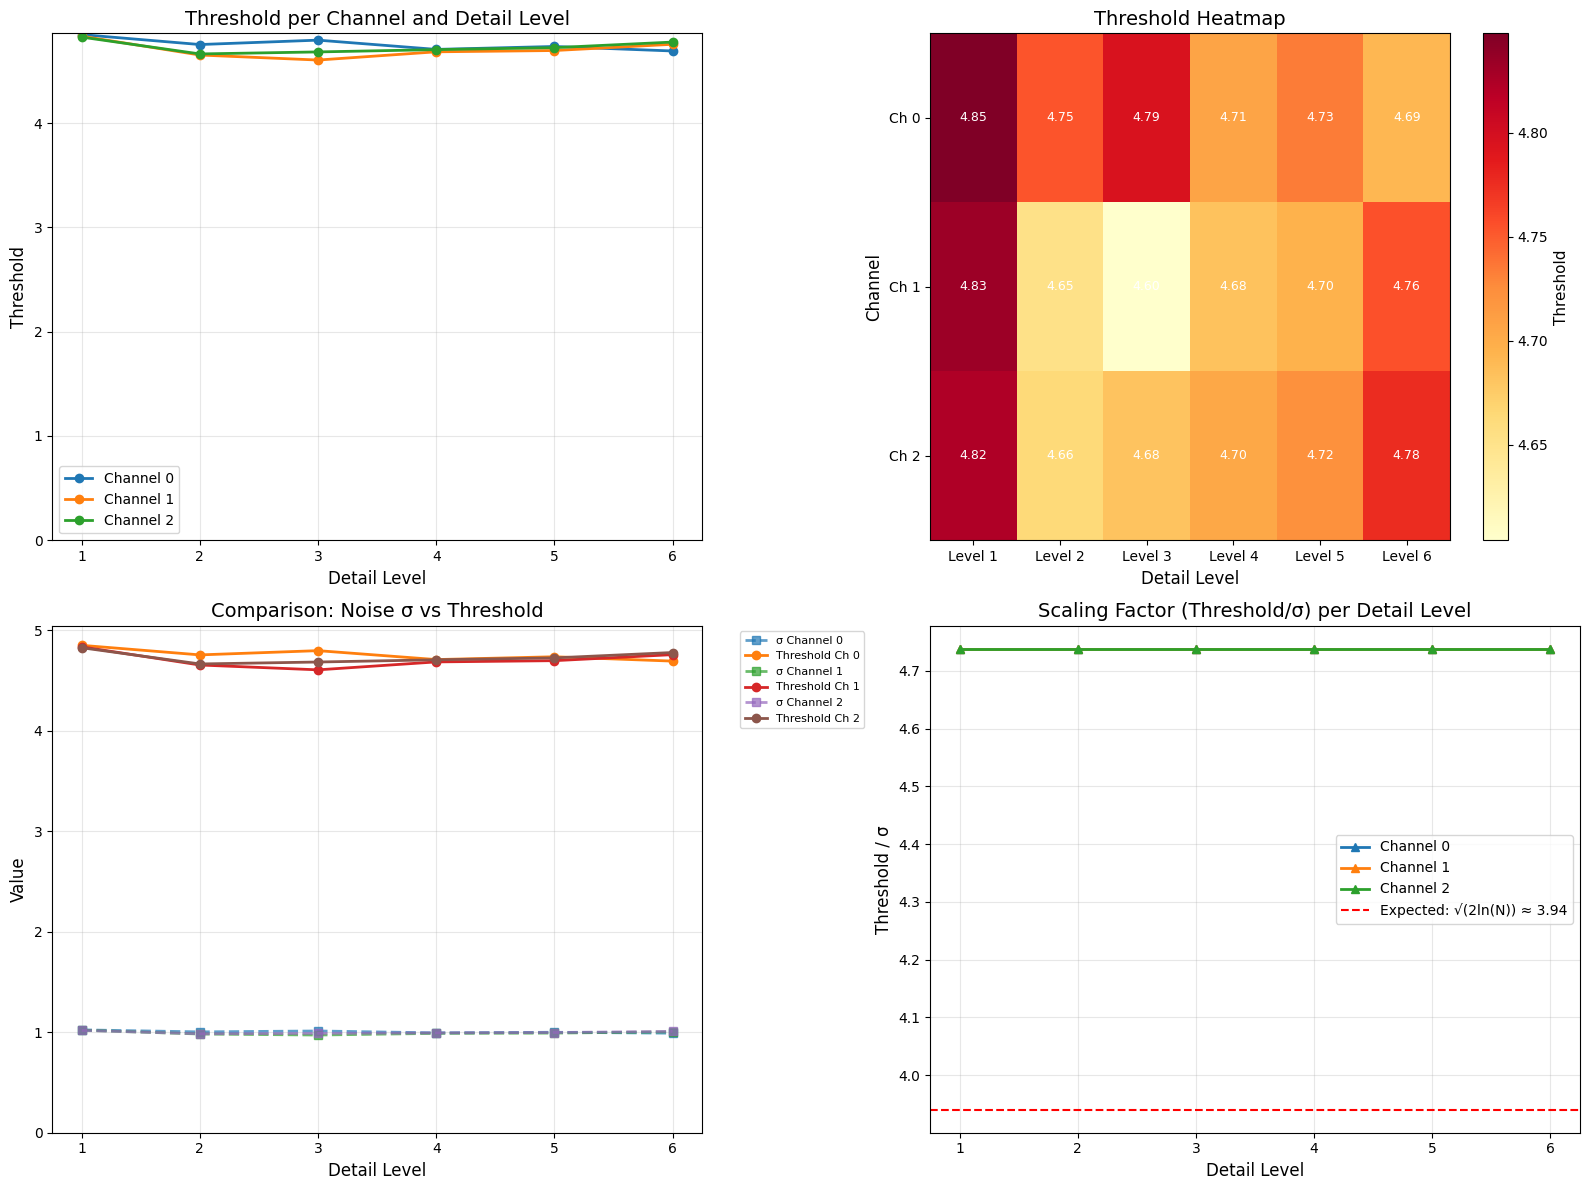


Summary Statistics for Thresholds:
Shape: (3, 6) (channels × detail levels)

Per Channel (mean threshold across all detail levels):
  Channel 0: mean=4.7544, std=0.0535
  Channel 1: mean=4.7037, std=0.0735
  Channel 2: mean=4.7285, std=0.0556

Per Detail Level (mean threshold across all channels):
  Level 1: mean=4.8348, std=0.0099
  Level 2: mean=4.6891, std=0.0452
  Level 3: mean=4.6936, std=0.0784
  Level 4: mean=4.6976, std=0.0104
  Level 5: mean=4.7174, std=0.0163
  Level 6: mean=4.7408, std=0.0363

Ratio Statistics (Threshold/σ):
Mean ratio: 4.7382
Std ratio: 0.0000
Expected ratio (√(2ln(N))): 3.9403


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array for easier manipulation
thresholds_array = np.array(chn_coeff_thresholds)  # Shape: (num_channels, num_detail_levels)
sigmas_array = np.array(chn_coeff_sigmas)  # Shape: (num_channels, num_detail_levels)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Line plot - threshold vs detail level for each channel
ax1 = axes[0, 0]
detail_levels = range(1, thresholds_array.shape[1] + 1)

for ch_idx in range(thresholds_array.shape[0]):
    ax1.plot(detail_levels, thresholds_array[ch_idx], marker='o', label=f'Channel {ch_idx}', linewidth=2)

ax1.set_xlabel('Detail Level', fontsize=12)
ax1.set_ylabel('Threshold', fontsize=12)
ax1.set_title('Threshold per Channel and Detail Level', fontsize=14)
ax1.set_xticks(detail_levels)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(bottom=0)

# Plot 2: Heatmap - channels vs detail levels (thresholds)
ax2 = axes[0, 1]
im1 = ax2.imshow(thresholds_array, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_xlabel('Detail Level', fontsize=12)
ax2.set_ylabel('Channel', fontsize=12)
ax2.set_title('Threshold Heatmap', fontsize=14)
ax2.set_xticks(range(thresholds_array.shape[1]))
ax2.set_xticklabels([f'Level {i+1}' for i in range(thresholds_array.shape[1])])
ax2.set_yticks(range(thresholds_array.shape[0]))
ax2.set_yticklabels([f'Ch {i}' for i in range(thresholds_array.shape[0])])

cbar1 = plt.colorbar(im1, ax=ax2)
cbar1.set_label('Threshold', fontsize=11)

# Add text annotations on heatmap
for i in range(thresholds_array.shape[0]):
    for j in range(thresholds_array.shape[1]):
        text = ax2.text(j, i, f'{thresholds_array[i, j]:.2f}',
                       ha="center", va="center", color="white", fontsize=9)

# Plot 3: Comparison - Sigma vs Threshold (line plot)
ax3 = axes[1, 0]
for ch_idx in range(sigmas_array.shape[0]):
    ax3.plot(detail_levels, sigmas_array[ch_idx], marker='s', label=f'σ Channel {ch_idx}', 
             linestyle='--', alpha=0.7, linewidth=2)
    ax3.plot(detail_levels, thresholds_array[ch_idx], marker='o', label=f'Threshold Ch {ch_idx}', 
             linewidth=2)

ax3.set_xlabel('Detail Level', fontsize=12)
ax3.set_ylabel('Value', fontsize=12)
ax3.set_title('Comparison: Noise σ vs Threshold', fontsize=14)
ax3.set_xticks(detail_levels)
ax3.grid(True, alpha=0.3)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.set_ylim(bottom=0)

# Plot 4: Ratio (Threshold / Sigma) to show scaling factor
ax4 = axes[1, 1]
ratio_array = thresholds_array / sigmas_array

for ch_idx in range(ratio_array.shape[0]):
    ax4.plot(detail_levels, ratio_array[ch_idx], marker='^', label=f'Channel {ch_idx}', linewidth=2)

ax4.set_xlabel('Detail Level', fontsize=12)
ax4.set_ylabel('Threshold / σ', fontsize=12)
ax4.set_title('Scaling Factor (Threshold/σ) per Detail Level', fontsize=14)
ax4.set_xticks(detail_levels)
ax4.grid(True, alpha=0.3)
ax4.legend()

# Add expected theoretical line
expected_ratio = np.sqrt(2 * np.log(len(chn_coeffs[0][1])))
ax4.axhline(y=expected_ratio, color='r', linestyle='--', 
            label=f'Expected: √(2ln(N)) ≈ {expected_ratio:.2f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Thresholds:")
print(f"Shape: {thresholds_array.shape} (channels × detail levels)")
print(f"\nPer Channel (mean threshold across all detail levels):")
for ch_idx in range(thresholds_array.shape[0]):
    mean_thr = np.mean(thresholds_array[ch_idx])
    std_thr = np.std(thresholds_array[ch_idx])
    print(f"  Channel {ch_idx}: mean={mean_thr:.4f}, std={std_thr:.4f}")

print(f"\nPer Detail Level (mean threshold across all channels):")
for level_idx in range(thresholds_array.shape[1]):
    mean_thr = np.mean(thresholds_array[:, level_idx])
    std_thr = np.std(thresholds_array[:, level_idx])
    print(f"  Level {level_idx+1}: mean={mean_thr:.4f}, std={std_thr:.4f}")

print(f"\nRatio Statistics (Threshold/σ):")
print(f"Mean ratio: {np.mean(ratio_array):.4f}")
print(f"Std ratio: {np.std(ratio_array):.4f}")
print(f"Expected ratio (√(2ln(N))): {expected_ratio:.4f}")

### Step 4: Apply soft thresholding (shrink coefficients)
- Coefficients below threshold → set to 0 (remove noise)
- Coefficients above threshold → shrink them by thr amount
    - This preserves AE burst shape better than hard thresholding
    - Example: if coeff=150 and thr=50 → becomes 100

In [21]:
chn_cD_thr = []

for ch_idx in range(signal_hp.shape[1]):
    cD_thr = []
    for level_idx, cD in enumerate(chn_coeffs[ch_idx][1:]):  # Use enumerate!
        thr = chn_coeff_thresholds[ch_idx][level_idx]  # Get corresponding threshold
        cD_thr.append(np.sign(cD) * np.maximum(np.abs(cD) - thr, 0.0))
    chn_cD_thr.append(cD_thr)

In [22]:
chn_cD_thr

[[array([-0.,  0., -0., ..., -0.,  0., -0.], shape=(2352,)),
  array([-0.,  0., -0., ..., -0.,  0., -0.], shape=(4696,)),
  array([ 0.,  0., -0., ..., -0.,  0.,  0.], shape=(9383,)),
  array([ 0.,  0., -0., ...,  0., -0.,  0.], shape=(18757,)),
  array([ 0., -0.,  0., ..., -0.,  0., -0.], shape=(37506,)),
  array([ 0.,  0., -0., ...,  0., -0., -0.], shape=(75004,))],
 [array([ 0., -0.,  0., ..., -0.,  0.,  0.], shape=(2352,)),
  array([ 0., -0.,  0., ...,  0., -0., -0.], shape=(4696,)),
  array([ 0., -0.,  0., ...,  0.,  0., -0.], shape=(9383,)),
  array([-0., -0.,  0., ...,  0., -0.,  0.], shape=(18757,)),
  array([ 0., -0.,  0., ..., -0.,  0., -0.], shape=(37506,)),
  array([ 0., -0.,  0., ...,  0., -0., -0.], shape=(75004,))],
 [array([-0., -0.,  0., ...,  0., -0.,  0.], shape=(2352,)),
  array([ 0., -0.,  0., ...,  0., -0.,  0.], shape=(4696,)),
  array([-0.,  0., -0., ..., -0.,  0.,  0.], shape=(9383,)),
  array([-0.,  0., -0., ...,  0., -0.,  0.], shape=(18757,)),
  array([ 0., -

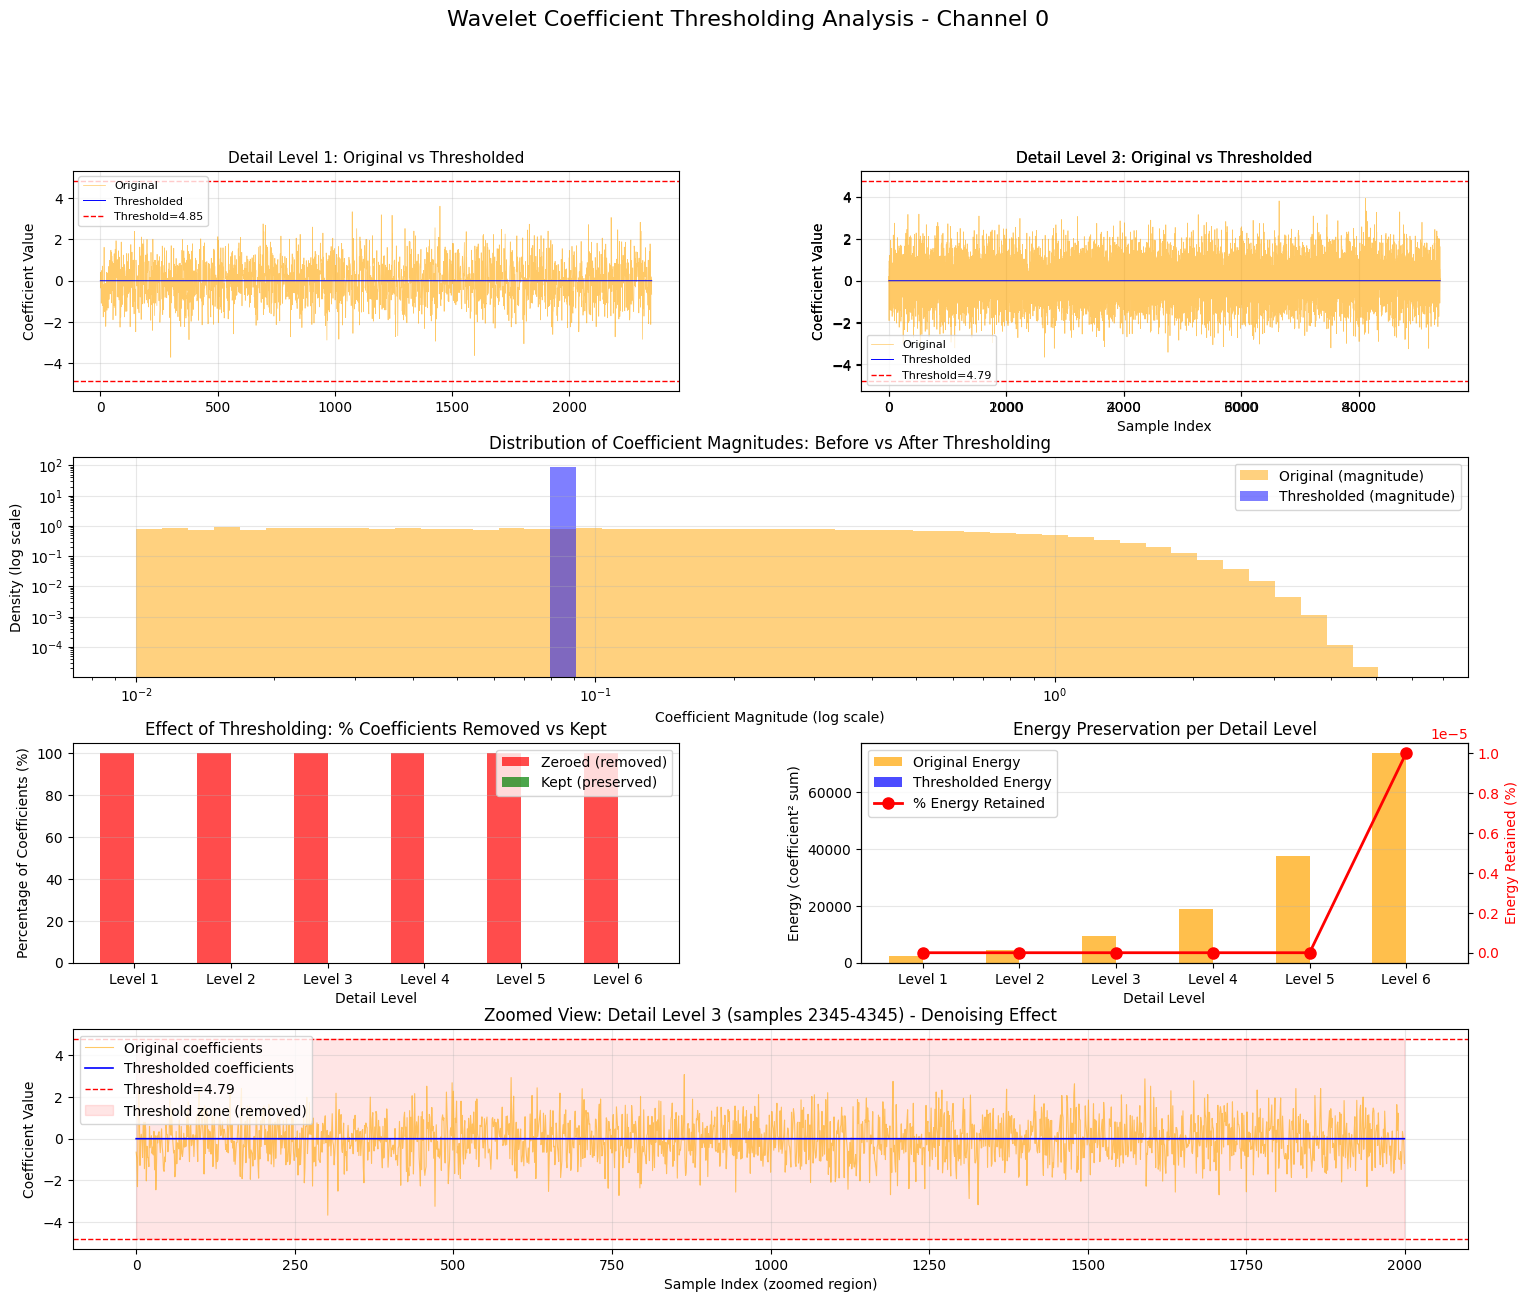


Thresholding Summary Statistics - Channel 0

Coefficients Analysis:

  Detail Level 1:
    Threshold: 4.8479
    Total coefficients: 2,352
    Zeroed (removed): 2,352 (100.0%)
    Kept (preserved): 0 (0.0%)
    Energy retained: 0.0%

  Detail Level 2:
    Threshold: 4.7527
    Total coefficients: 4,696
    Zeroed (removed): 4,696 (100.0%)
    Kept (preserved): 0 (0.0%)
    Energy retained: 0.0%

  Detail Level 3:
    Threshold: 4.7949
    Total coefficients: 9,383
    Zeroed (removed): 9,383 (100.0%)
    Kept (preserved): 0 (0.0%)
    Energy retained: 0.0%

  Detail Level 4:
    Threshold: 4.7061
    Total coefficients: 18,757
    Zeroed (removed): 18,757 (100.0%)
    Kept (preserved): 0 (0.0%)
    Energy retained: 0.0%

  Detail Level 5:
    Threshold: 4.7341
    Total coefficients: 37,506
    Zeroed (removed): 37,506 (100.0%)
    Kept (preserved): 0 (0.0%)
    Energy retained: 0.0%

  Detail Level 6:
    Threshold: 4.6909
    Total coefficients: 75,004
    Zeroed (removed): 75,003 (

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a channel to visualize (or loop through all)
ch_idx = 0  # Change this to visualize different channels

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# Row 1: Original vs Thresholded coefficients (overview)
for level_idx in range(min(3, len(chn_cD_thr[ch_idx]))):  # Show first 3 detail levels
    ax = fig.add_subplot(gs[0, level_idx] if level_idx < 2 else gs[0, 1])
    
    cD_original = chn_coeffs[ch_idx][level_idx + 1]
    cD_thresholded = chn_cD_thr[ch_idx][level_idx]
    threshold = chn_coeff_thresholds[ch_idx][level_idx]
    
    # Plot original and thresholded on same axes
    ax.plot(cD_original, color='orange', alpha=0.6, linewidth=0.5, label='Original')
    ax.plot(cD_thresholded, color='blue', linewidth=0.7, label='Thresholded')
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1, label=f'Threshold={threshold:.2f}')
    ax.axhline(y=-threshold, color='red', linestyle='--', linewidth=1)
    
    ax.set_title(f'Detail Level {level_idx + 1}: Original vs Thresholded', fontsize=11)
    ax.set_ylabel('Coefficient Value')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    if level_idx == 1:
        ax.set_xlabel('Sample Index')

# Row 2: Histogram comparison (coefficient magnitude distribution)
ax_hist = fig.add_subplot(gs[1, :])
all_original_mags = []
all_thresholded_mags = []
labels = []

for level_idx in range(len(chn_cD_thr[ch_idx])):
    cD_original = chn_coeffs[ch_idx][level_idx + 1]
    cD_thresholded = chn_cD_thr[ch_idx][level_idx]
    all_original_mags.append(np.abs(cD_original))
    all_thresholded_mags.append(np.abs(cD_thresholded))
    labels.append(f'Level {level_idx + 1}')

# Flatten all magnitudes
all_orig_flat = np.concatenate(all_original_mags)
all_thr_flat = np.concatenate(all_thresholded_mags)

# Histogram comparison
bins = np.logspace(-2, np.log10(np.max(all_orig_flat) + 1), 50)
ax_hist.hist(all_orig_flat, bins=bins, alpha=0.5, label='Original (magnitude)', color='orange', density=True)
ax_hist.hist(all_thr_flat, bins=bins, alpha=0.5, label='Thresholded (magnitude)', color='blue', density=True)
ax_hist.set_xscale('log')
ax_hist.set_yscale('log')
ax_hist.set_xlabel('Coefficient Magnitude (log scale)')
ax_hist.set_ylabel('Density (log scale)')
ax_hist.set_title('Distribution of Coefficient Magnitudes: Before vs After Thresholding', fontsize=12)
ax_hist.legend()
ax_hist.grid(True, alpha=0.3)

# Row 3: Statistics - Coefficients removed per level
ax_stats = fig.add_subplot(gs[2, 0])
levels = []
frac_zeroed = []
frac_kept = []
num_zeros = []
num_kept = []

for level_idx in range(len(chn_cD_thr[ch_idx])):
    cD_original = chn_coeffs[ch_idx][level_idx + 1]
    cD_thresholded = chn_cD_thr[ch_idx][level_idx]
    
    num_zero = np.sum(cD_thresholded == 0)
    num_kept_val = len(cD_thresholded) - num_zero
    
    levels.append(level_idx + 1)
    frac_zeroed.append(num_zero / len(cD_thresholded) * 100)
    frac_kept.append(num_kept_val / len(cD_thresholded) * 100)
    num_zeros.append(num_zero)
    num_kept.append(num_kept_val)

x = np.arange(len(levels))
width = 0.35
ax_stats.bar(x - width/2, frac_zeroed, width, label='Zeroed (removed)', color='red', alpha=0.7)
ax_stats.bar(x + width/2, frac_kept, width, label='Kept (preserved)', color='green', alpha=0.7)
ax_stats.set_xlabel('Detail Level')
ax_stats.set_ylabel('Percentage of Coefficients (%)')
ax_stats.set_title('Effect of Thresholding: % Coefficients Removed vs Kept', fontsize=12)
ax_stats.set_xticks(x)
ax_stats.set_xticklabels([f'Level {l}' for l in levels])
ax_stats.legend()
ax_stats.grid(True, alpha=0.3, axis='y')

# Row 3: Energy preservation
ax_energy = fig.add_subplot(gs[2, 1])
original_energy = []
thresholded_energy = []
energy_retained = []

for level_idx in range(len(chn_cD_thr[ch_idx])):
    cD_original = chn_coeffs[ch_idx][level_idx + 1]
    cD_thresholded = chn_cD_thr[ch_idx][level_idx]
    
    orig_e = np.sum(cD_original ** 2)
    thr_e = np.sum(cD_thresholded ** 2)
    
    original_energy.append(orig_e)
    thresholded_energy.append(thr_e)
    energy_retained.append(thr_e / orig_e * 100 if orig_e > 0 else 0)

x = np.arange(len(levels))
ax_energy_twin = ax_energy.twinx()
bars1 = ax_energy.bar(x - width/2, original_energy, width, label='Original Energy', color='orange', alpha=0.7)
bars2 = ax_energy.bar(x + width/2, thresholded_energy, width, label='Thresholded Energy', color='blue', alpha=0.7)
line = ax_energy_twin.plot(x, energy_retained, 'ro-', linewidth=2, markersize=8, label='% Energy Retained')

ax_energy.set_xlabel('Detail Level')
ax_energy.set_ylabel('Energy (coefficient² sum)', color='black')
ax_energy_twin.set_ylabel('Energy Retained (%)', color='red')
ax_energy.set_title('Energy Preservation per Detail Level', fontsize=12)
ax_energy.set_xticks(x)
ax_energy.set_xticklabels([f'Level {l}' for l in levels])
ax_energy.tick_params(axis='y', labelcolor='black')
ax_energy_twin.tick_params(axis='y', labelcolor='red')
ax_energy.grid(True, alpha=0.3, axis='y')

# Combine legends
lines1, labels1 = ax_energy.get_legend_handles_labels()
lines2, labels2 = ax_energy_twin.get_legend_handles_labels()
ax_energy.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Row 4: Zoomed view of a specific region (showing denoising effect)
ax_zoom = fig.add_subplot(gs[3, :])

# Pick a detail level and region with activity
level_to_show = 2  # Middle detail level
zoom_start = len(chn_cD_thr[ch_idx][level_to_show]) // 4
zoom_end = zoom_start + 2000  # Show 2000 samples

cD_orig = chn_coeffs[ch_idx][level_to_show + 1][zoom_start:zoom_end]
cD_thr = chn_cD_thr[ch_idx][level_to_show][zoom_start:zoom_end]
thr = chn_coeff_thresholds[ch_idx][level_to_show]

ax_zoom.plot(cD_orig, color='orange', alpha=0.6, linewidth=0.8, label='Original coefficients')
ax_zoom.plot(cD_thr, color='blue', linewidth=1.2, label='Thresholded coefficients')
ax_zoom.axhline(y=thr, color='red', linestyle='--', linewidth=1, label=f'Threshold={thr:.2f}')
ax_zoom.axhline(y=-thr, color='red', linestyle='--', linewidth=1)
ax_zoom.fill_between(range(len(cD_thr)), -thr, thr, alpha=0.1, color='red', label='Threshold zone (removed)')

ax_zoom.set_xlabel('Sample Index (zoomed region)')
ax_zoom.set_ylabel('Coefficient Value')
ax_zoom.set_title(f'Zoomed View: Detail Level {level_to_show + 1} (samples {zoom_start}-{zoom_end}) - Denoising Effect', fontsize=12)
ax_zoom.legend()
ax_zoom.grid(True, alpha=0.3)

fig.suptitle(f'Wavelet Coefficient Thresholding Analysis - Channel {ch_idx}', fontsize=16, y=0.995)
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"Thresholding Summary Statistics - Channel {ch_idx}")
print(f"{'='*60}")
print(f"\nCoefficients Analysis:")
for level_idx in range(len(chn_cD_thr[ch_idx])):
    cD_original = chn_coeffs[ch_idx][level_idx + 1]
    cD_thresholded = chn_cD_thr[ch_idx][level_idx]
    threshold = chn_coeff_thresholds[ch_idx][level_idx]
    
    num_total = len(cD_thresholded)
    num_zeroed = np.sum(cD_thresholded == 0)
    num_kept = num_total - num_zeroed
    
    orig_energy = np.sum(cD_original ** 2)
    thr_energy = np.sum(cD_thresholded ** 2)
    energy_pct = (thr_energy / orig_energy * 100) if orig_energy > 0 else 0
    
    print(f"\n  Detail Level {level_idx + 1}:")
    print(f"    Threshold: {threshold:.4f}")
    print(f"    Total coefficients: {num_total:,}")
    print(f"    Zeroed (removed): {num_zeroed:,} ({num_zeroed/num_total*100:.1f}%)")
    print(f"    Kept (preserved): {num_kept:,} ({num_kept/num_total*100:.1f}%)")
    print(f"    Energy retained: {energy_pct:.1f}%")

### Step 5: Reconstruct (put it back together)
- Combines the cleaned coefficients back into a denoised signal
- Result: noise removed, AE bursts preserved

In [24]:
# Reconstruct denoised signal per channel
denoised_channels = []

for ch_idx in range(signal_hp.shape[1]):
    # Combine approximation (unchanged) + thresholded detail coefficients
    denoised_coeffs = [chn_coeffs[ch_idx][0]] + chn_cD_thr[ch_idx]
    
    # Reconstruct the signal
    rec = pywt.waverec(denoised_coeffs, wavelet)
    denoised_channels.append(rec)

# Convert to numpy array if needed
denoised_signal = np.array(denoised_channels).T  # Shape: (n_samples, n_channels)

c:\Users\nguye\Documents\GitHub\orion-ae-study\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


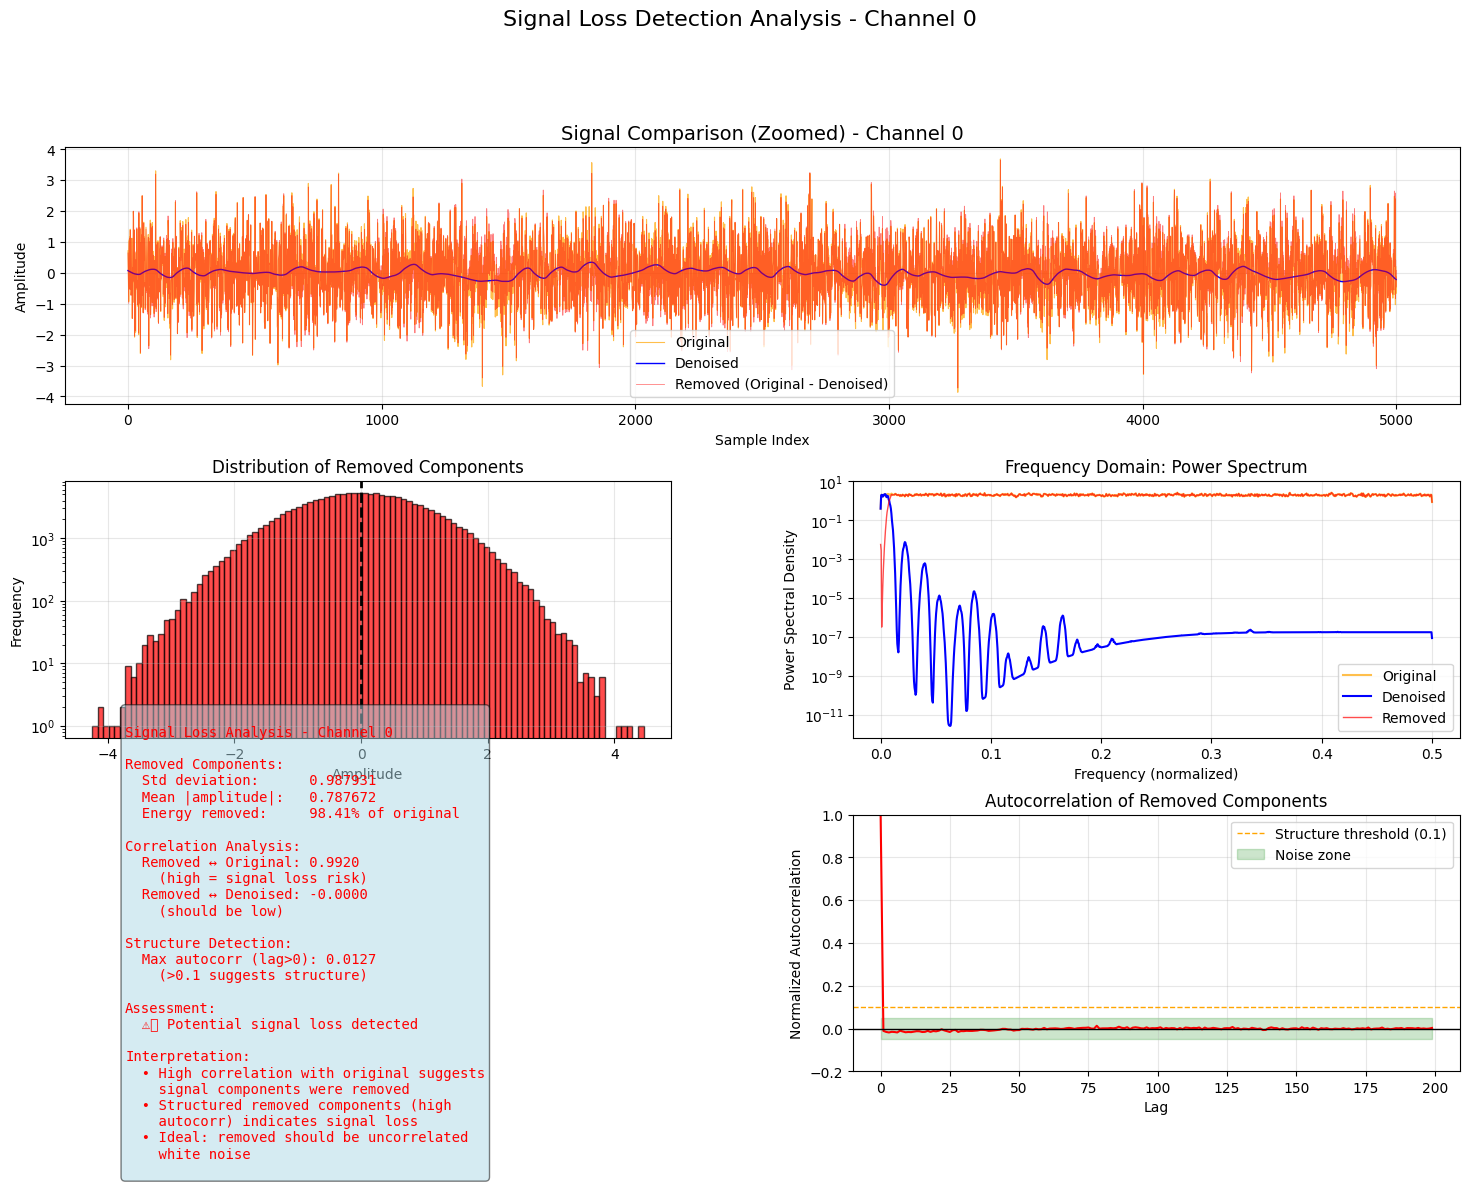


Signal Loss Assessment - Channel 0

📊 Key Indicators:
  Correlation (removed ↔ original): 0.9920
    ⚠️  WARNING: High correlation suggests signal components were removed!

  Correlation (removed ↔ denoised): -0.0000
    (Should be close to 0 if only noise was removed)

  Maximum autocorrelation (structure): 0.0127
    ✓ Good: Removed components appear unstructured (likely noise)

  Energy removed: 98.41% of original energy

💡 Recommendations:
  • Consider using a less aggressive threshold
  • Check if AE bursts are being preserved
  • Review threshold calculation parameters


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.stats import pearsonr

# Choose a channel to analyze
ch_idx = 0

# Extract signals
original = signal_hp[:min_len, ch_idx]
denoised = denoised_signal[:min_len, ch_idx]
removed = original - denoised

# Create comprehensive signal loss analysis
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Original vs Denoised (for reference)
ax1 = fig.add_subplot(gs[0, :])
zoom_start = len(original) // 3
zoom_end = zoom_start + 5000

ax1.plot(original[zoom_start:zoom_end], color='orange', alpha=0.7, linewidth=0.8, label='Original')
ax1.plot(denoised[zoom_start:zoom_end], color='blue', linewidth=1, label='Denoised')
ax1.plot(removed[zoom_start:zoom_end], color='red', alpha=0.5, linewidth=0.6, label='Removed (Original - Denoised)')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Signal Comparison (Zoomed) - Channel {ch_idx}', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of removed components
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(removed, bins=100, alpha=0.7, color='red', edgecolor='black')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Amplitude')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Removed Components', fontsize=12)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Plot 3: Power Spectral Density comparison
ax3 = fig.add_subplot(gs[1, 1])
freq_orig, psd_orig = signal.welch(original, nperseg=2048)
freq_den, psd_den = signal.welch(denoised, nperseg=2048)
freq_rem, psd_rem = signal.welch(removed, nperseg=2048)

ax3.semilogy(freq_orig, psd_orig, color='orange', alpha=0.7, label='Original', linewidth=1.5)
ax3.semilogy(freq_den, psd_den, color='blue', label='Denoised', linewidth=1.5)
ax3.semilogy(freq_rem, psd_rem, color='red', alpha=0.7, label='Removed', linewidth=1)
ax3.set_xlabel('Frequency (normalized)')
ax3.set_ylabel('Power Spectral Density')
ax3.set_title('Frequency Domain: Power Spectrum', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Signal loss indicators
ax4 = fig.add_subplot(gs[2, 0])
ax4.axis('off')

# Key metrics for signal loss detection
removed_std = np.std(removed)
removed_mean = np.mean(np.abs(removed))

# Correlation between removed and original (if high, suggests signal loss)
corr_removed_orig = np.corrcoef(removed, original)[0, 1]

# Correlation between removed and denoised (should be low if only noise removed)
corr_removed_den = np.corrcoef(removed, denoised)[0, 1]

# Energy ratio: removed energy / original energy
energy_original = np.sum(original**2)
energy_removed = np.sum(removed**2)
energy_ratio = energy_removed / energy_original * 100 if energy_original > 0 else 0

# Check for structure in removed signal (using autocorrelation)
# If autocorrelation shows structure, it's likely signal, not just noise
autocorr_removed = np.correlate(removed, removed, mode='full')
autocorr_removed = autocorr_removed[len(autocorr_removed)//2:]
autocorr_removed = autocorr_removed[:1000] / autocorr_removed[0]  # Normalize and take first 1000 lags

# Peak autocorrelation (excluding lag 0)
max_autocorr = np.max(autocorr_removed[1:100])  # Check first 100 lags

# Signal loss assessment
if corr_removed_orig > 0.3 or max_autocorr > 0.1:
    loss_warning = "⚠️ Potential signal loss detected"
    loss_color = "red"
else:
    loss_warning = "✓ Minimal signal loss (mostly noise removed)"
    loss_color = "green"

stats_text = f"""
Signal Loss Analysis - Channel {ch_idx}

Removed Components:
  Std deviation:      {removed_std:.6f}
  Mean |amplitude|:   {removed_mean:.6f}
  Energy removed:     {energy_ratio:.2f}% of original

Correlation Analysis:
  Removed ↔ Original: {corr_removed_orig:.4f}
    (high = signal loss risk)
  Removed ↔ Denoised: {corr_removed_den:.4f}
    (should be low)

Structure Detection:
  Max autocorr (lag>0): {max_autocorr:.4f}
    (>0.1 suggests structure)

Assessment:
  {loss_warning}

Interpretation:
  • High correlation with original suggests
    signal components were removed
  • Structured removed components (high
    autocorr) indicates signal loss
  • Ideal: removed should be uncorrelated
    white noise
"""

ax4.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
         verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
         color=loss_color if 'Potential' in loss_warning else 'black')

# Plot 5: Autocorrelation of removed components
ax5 = fig.add_subplot(gs[2, 1])
lags = np.arange(len(autocorr_removed))
ax5.plot(lags[:200], autocorr_removed[:200], color='red', linewidth=1.5)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.axhline(y=0.1, color='orange', linestyle='--', linewidth=1, label='Structure threshold (0.1)')
ax5.fill_between(lags[:200], -0.05, 0.05, alpha=0.2, color='green', label='Noise zone')
ax5.set_xlabel('Lag')
ax5.set_ylabel('Normalized Autocorrelation')
ax5.set_title('Autocorrelation of Removed Components', fontsize=12)
ax5.set_ylim([-0.2, 1.0])
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.suptitle(f'Signal Loss Detection Analysis - Channel {ch_idx}', fontsize=16, y=0.995)
plt.show()

# Print detailed assessment
print(f"\n{'='*70}")
print(f"Signal Loss Assessment - Channel {ch_idx}")
print(f"{'='*70}")

print(f"\n📊 Key Indicators:")
print(f"  Correlation (removed ↔ original): {corr_removed_orig:.4f}")
if corr_removed_orig > 0.3:
    print(f"    ⚠️  WARNING: High correlation suggests signal components were removed!")
elif corr_removed_orig > 0.1:
    print(f"    ⚠️  CAUTION: Moderate correlation - check for signal loss")
else:
    print(f"    ✓ Good: Low correlation - mostly noise removed")

print(f"\n  Correlation (removed ↔ denoised): {corr_removed_den:.4f}")
print(f"    (Should be close to 0 if only noise was removed)")

print(f"\n  Maximum autocorrelation (structure): {max_autocorr:.4f}")
if max_autocorr > 0.1:
    print(f"    ⚠️  WARNING: Removed components show structure (signal loss likely)")
else:
    print(f"    ✓ Good: Removed components appear unstructured (likely noise)")

print(f"\n  Energy removed: {energy_ratio:.2f}% of original energy")

print(f"\n💡 Recommendations:")
if corr_removed_orig > 0.3 or max_autocorr > 0.1:
    print(f"  • Consider using a less aggressive threshold")
    print(f"  • Check if AE bursts are being preserved")
    print(f"  • Review threshold calculation parameters")
else:
    print(f"  • Denoising appears to preserve signal well")
    print(f"  • Removed components are likely noise")